# Обыкновенные дифференциальные уравнения

Обыкновенные дифференциальные уравнения (ОДУ) можно решать в численном виде с помощью метода ```scipy.integrate.odeint``` или метода ```scipy.integrate.solve_ivp``` («solve an initial value problem» – «решение задачи с начальными условиями (или задачи Коши)»). Второй метод появился в  версии 1.0 библиотеки ```SciPy```, и именно он рекомендуется для практического использования. Тем не менее в ранее написанном коде продолжает применяться ```odeint```. Метод ```solve_ivp``` решает дифференциальные уравнения первого порядка, но для решения ДУ более высоких порядков необходимо сначала разложить их в систему ДУ первого порядка, как описано ниже.

## Решение одного ОДУ первого порядка

В самом простом варианте использования для решения одного ОДУ первого
порядка

![](images/image1.png)

метод ```solve_ivp``` принимает три аргумента: объект функции, возвращаемой
```dy/dt```, начальный и конечный моменты времени для интегрирования и набор
начальных условий ```y0```. Механизм решения ОДУ выбирает и возвращает последовательность подходящих моментов (точек) времени (если они не заданы),
в которых выполняется интегрирование.

Например, рассмотрим дифференциальное уравнение первого порядка,
описывающее скорость реакции ```A → P``` в выражении концентрации реагента A:

![](images/image2.png)

Для этого примера существует легко выводимое аналитическое решение:

![](images/image3.png)

где ```[A]0``` – начальная концентрация реагента ```[A]```.

Для решения этого уравнения в численном виде с помощью ```solve_ivp``` необходимо записать его в форме, показанной выше, с единственной зависимой переменной ```y(t) ≡ [A]```, которая является функцией от независимой переменной ```t (время)```. Получаем:

![](images/image4.png)

Необходимо определить функцию, возвращающую ```dy/dt```, как ```f(t,y)``` (в общем
случае это функция и от ```t```, и от ```y```), которая в нашем случае весьма проста:

In [2]:
def dydt(t, y):
    return -k * y

Здесь порядок аргументов важен. Начальный и конечный моменты (точки)
времени ```t_span``` должны передаваться как кортеж ```(t0, tf)```, а начальные условия должны быть представлены объектом типа массив, даже если, как в рассматриваемом здесь случае, передается только одно значение. Получаем:

```soln = solve_ivp(dydt, (t0, tf), [y0])```

Возвращаемый объект ```soln``` –это экземпляр класса ```OdeResult```, который определяет ряд важных свойств, включая массивы ```soln.t``` для точек времени, используемых при интегрировании, ```soln.y``` со значениями решения в этих точках времени и ```soln.success``` – логический флаг, сообщающий, успешно или нет механизм решения ДУ достиг требуемой конечной точки времени.
Программа, сравнивающая численный и аналитический результаты для реакции при ```k = 0.2 1/с``` и ```y(0) ≡ [A]0 = 100```, приведена в листинге 1. Полученный
график изображен на рис. 1.

Листинг 1. Кинетика реакции первого порядка

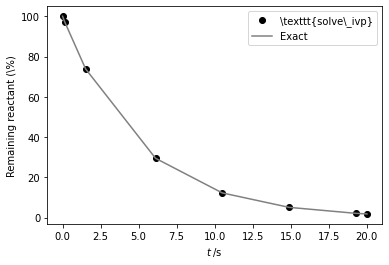

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# Постоянная скорость реакции первого порядка, 1/с.
k = 0.2
# Начальное условие для y: 100 % реагента в момент времени t = 0.
y0 = 100
# Начальная и конечная точки (моменты) времени для интегрирования.
t0, tf = 0, 20
def dydt(t, y):
    """ Return dy/dt = f(t, y) at time t. """
    """ Возвращает dy/dt = f(t, y) в момент времени t. """
    return -k * y
# Интегрирование дифференциального уравнения.
soln = solve_ivp(dydt, (t0, tf), [y0])
t, y = soln.t, soln.y[0]
# Построение графика и сравнение численного и точного (аналитического) решений.
plt.plot(t, y, 'o', color='k', label=r'\texttt{solve\_ivp}')
plt.plot(t, y0 * np.exp(-k*t), color='gray', label='Exact')
plt.xlabel(r'$t\;/\mathrm{s}$')
plt.ylabel('Remaining reactant (\%)')
plt.legend()
plt.show()

**Рис. 1**. Экспоненциальное снижение концентрации реагента в реакции первого порядка:
точное решение и решение численным методом с использованием точек времени,
выбранных механизмом решения ОДУ

Такая методика хорошо подходит, если все, что требуется, – это конечная
концентрация реагента, но для отслеживания изменений концентрации с более высокой разрешающей способностью по времени можно передать специальную последовательность точек времени в аргументе ```t_eval```:

И все же лучше присвоить аргументу ```dense_output``` значение True, чтобы
определить объект ```OdeSolution``` с именем ```sol``` как один из возвращаемых объектов. Это можно использовать для генерации интерполяционных значений
решения для промежуточных значений точек времени:

Обратите внимание: объект ```soln.sol``` является вызываемым: значение независимой переменной – времени – передается в него, и возвращается массив
решения в этот момент времени. Здесь имеется только одна зависимая переменная ```y```, поэтому массив индексируется по ```[0]```.
График с  точками решения y, аналогичный полученному в  предыдущем
примере, показан на рис. 2.

![](images/image5.png)

**Рис. 2**. Экспоненциальное снижение концентрации реагента в реакции первого порядка:
точное решение и решение численным методом с использованием предварительно
определенных точек времени

Как и при использовании группы методов ```quad```, если функция, возвращающая производную, требует дополнительных аргументов, то их можно передать
в метод ```solve_ivp``` в параметре ```args```. В приведенном выше примере ```k``` относится к глобальной области видимости, но эту переменную можно было бы передать
явно:

Обратите внимание: дополнительные параметры обязательно должны указываться после независимой и  зависимой переменных. Тогда вызов метода ```solve_ivp``` мог бы выглядеть следующим образом:

Как ни странно, но возможность передачи дополнительных аргументов
в ```args``` была добавлена только в версии ```SciPy 1.4```. Другим способом передачи
аргументов из области видимости вызывающей стороны в  функцию вычисления производной ```dydt``` является использование в качестве обертки для этой
функции лямбда-выражения:

## Примеры

Скорость изменения функции относительно независимой переменной может варьироваться, и это то, чем являются производные. Когда существует переменная величина и переменная скорость изменения, чаще всего используется производная.

Python ```Scipy``` имеет метод в модуле , который находит значение точки для n-й производной функции. ```derivative()scipy.misc```

Синтаксис приведен ниже.


Где параметры:

- func: это функция ввода.
- x0(float): Точка, в которой можно найти n-ю производную.
- dx(float): это интервал.
- n(int): порядок производной. Значение по умолчанию — 1.
- args(tuple): используется для предоставления аргументов.
- order(int): Используйте только нечетное количество точек.

In [25]:
from scipy import misc
def f(x):
    return x**3
misc.derivative(f,1.5)

7.75

## Вычисление второй производной функции

Вторая производная, грубо говоря, измеряет, как изменяется скорость изменения самой величины. Например, вторая производная положения объекта по времени — это мгновенное ускорение объекта или скорость изменения скорости объекта по времени.

Давайте найдем вторую производную любой функции, выполнив следующие шаги:

Импортируйте необходимые библиотеки, используя приведенный ниже код Python.

In [26]:
def fun(x):
    return x**3 + x**2

In [35]:
misc.derivative(f,1,n=2,dx=1e-4)

5.999999985739635

## Производная массива функции

Чтобы вычислить производную массива, мы будем использовать цикл Python с функцией производной в этом разделе.

Определите функции, используя lambda-функцию, производную которой нам нужно найти, используя приведенный ниже код.

In [36]:
from scipy.misc import derivative
f1 = lambda x: x**2+3*x+2
f2 = lambda x: x**3+3*x+2
fun=[f1,f2]

Создайте массив вышеуказанных функций. Вычислите производную массива, содержащего функции.

In [37]:
for i in range(len(fun)):
    ans = derivative(fun[i],1)
    print('Derivative of {} function is'.format(i+1),ans)

Derivative of 1 function is 5.0
Derivative of 2 function is 7.0


Приведенный выше вывод содержит производную от вышеуказанных функций 5.0 и 7.0.

## Вторая производная от массива фуккции

В этом разделе мы будем использовать цикл Python с функцией производной для вычисления второй производной массива.

Давайте посмотрим на примере, выполнив следующие шаги:

Импортируйте необходимые библиотеки, используя приведенный ниже код Python.

Определите функции, используя lambda-функцию, производную которой нам нужно найти, используя приведенный ниже код.

In [38]:
func1 = lambda x: x**4+2*x**2+2
func2 = lambda x: x**3+2*x**2+2

Создайте массив вышеуказанных функций, используя параметр метода, ```derivative()``` используя приведенный ниже код.

In [41]:
func=[func1,func2]

Вычислите вторую производную массива, содержащего функции, используя приведенный ниже код.

In [42]:
for i in range(len(fun)):
    ans = derivative(fun[i],1,n=2)
    print('Derivative of {} function is'.format(i+1),ans)

Derivative of 1 function is 2.0
Derivative of 2 function is 6.0


В приведенном выше коде мы передаем параметр ```n=2``` в метод производной() для вычисления производной второго порядка функций в массиве.

## Производная от массива. Графики

Мы уже узнали о том, как вычислить производную из приведенного выше подраздела, теперь мы вычислим производную и построим эту производную, чтобы увидеть, как она выглядит.

Давайте вычислим и построим производную, выполнив следующие шаги:

Импортируйте необходимые методы или библиотеки, используя приведенный ниже код Python.

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import derivative

Теперь определите функцию, используя приведенный ниже код.

In [45]:
def fun(x):
    return 3*x*x*x+x+2

Вычислите производную вышеуказанной функции, используя приведенный ниже код.

In [47]:
def derivate(x):
    return derivative(fun, x)

Определите интервалы по оси X, используя приведенный ниже код.

In [49]:
y_val = np.linspace(-10, 10)

Постройте приведенную выше функцию и производную, используя приведенный ниже код.

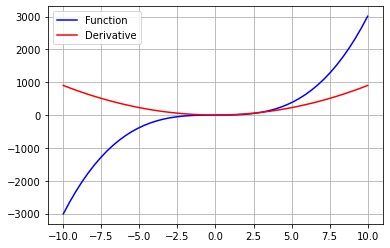

In [50]:
plt.plot(y_val, fun(y_val), color='blue', label='Function')

plt.plot(y_val, derivate(y_val), color='red', label='Derivative')

plt.legend(loc='upper left')
plt.grid(True)

## Упражнения


 Найти первую и вторую производные, а таже построить график функции, первой и второй ее производных для cos(x), sin(x), tg(x), ctg(x)